Note: Could not add basemap: Stamen
Note: Could not add basemap: Stamen
Note: Could not add basemap: Stamen
Note: Could not add basemap: Stamen
Maps created and saved as:
- osha_injuries_texas_all_years.png
- osha_injuries_colorado_all_years.png
- osha_injuries_texas_2023.png
- osha_injuries_colorado_2023.png
Time series plot created and saved as:
- osha_injuries_time_series_by_state.png


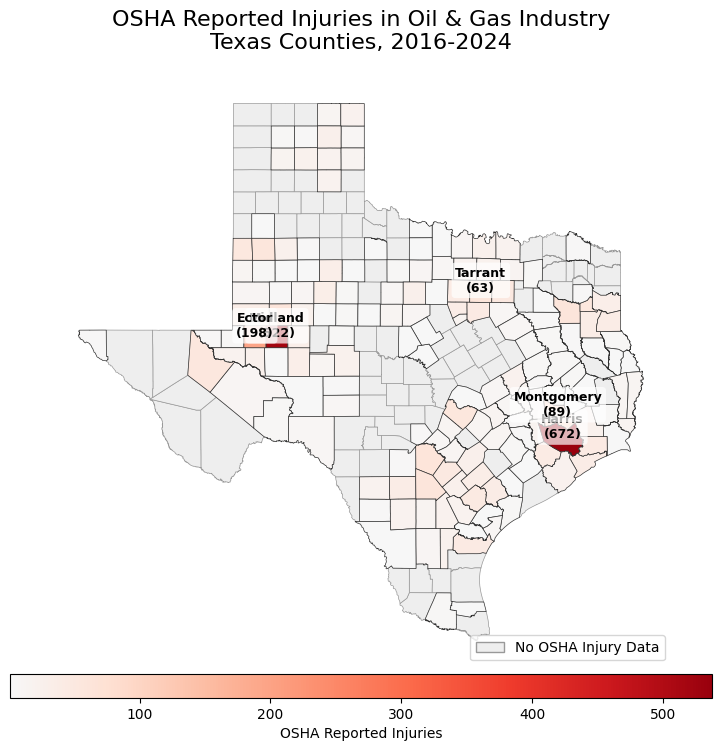

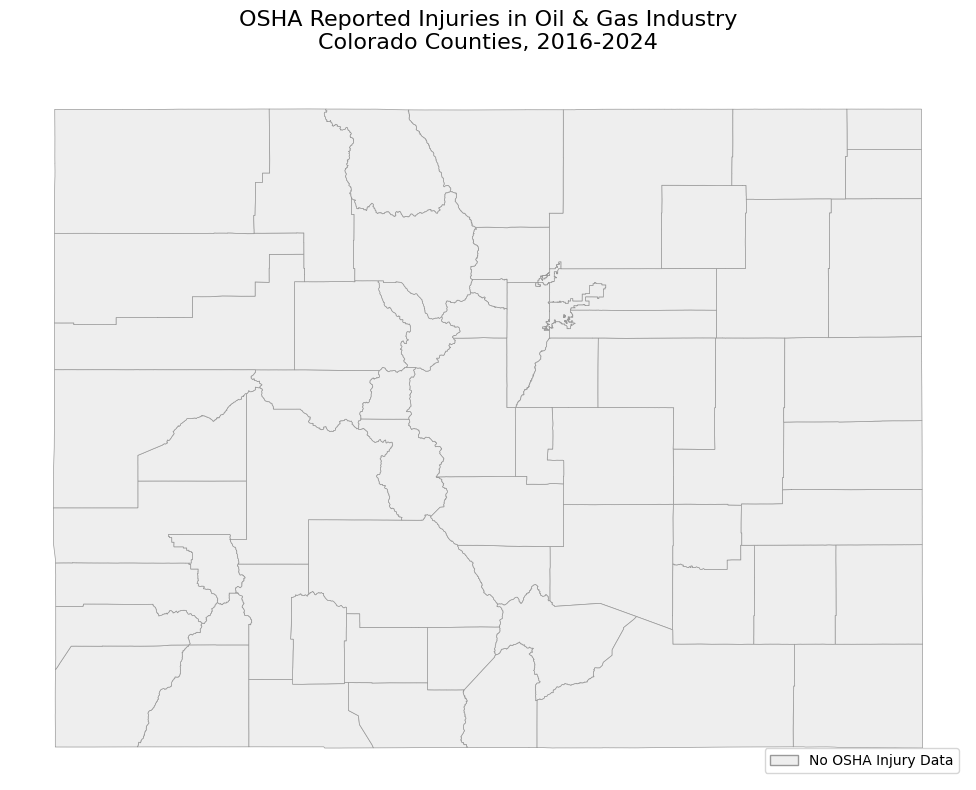

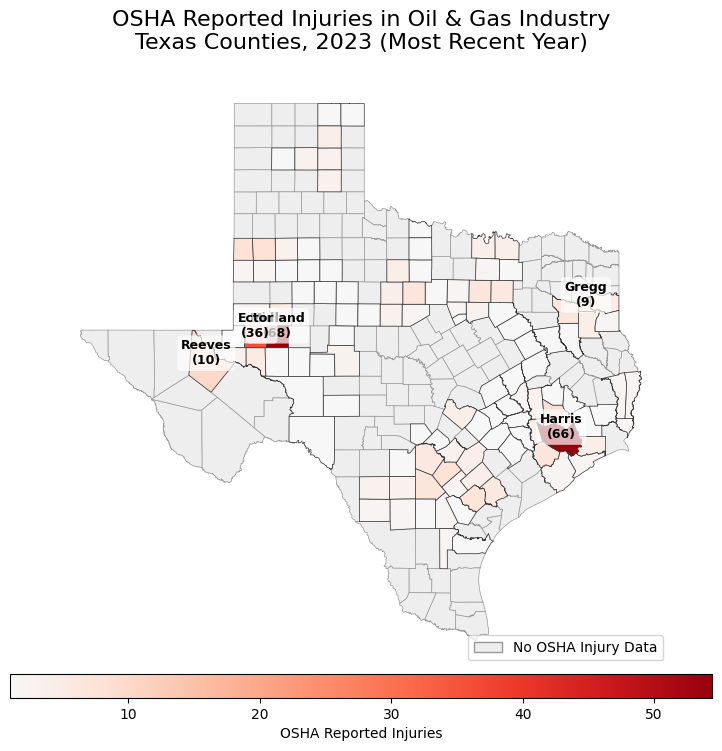

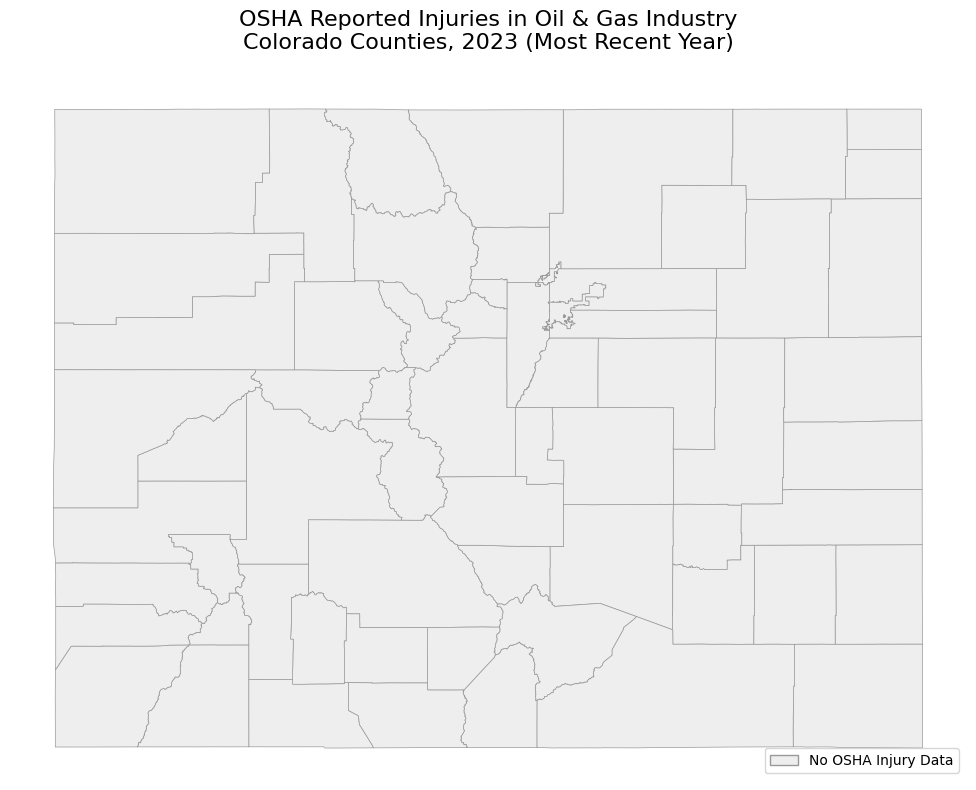

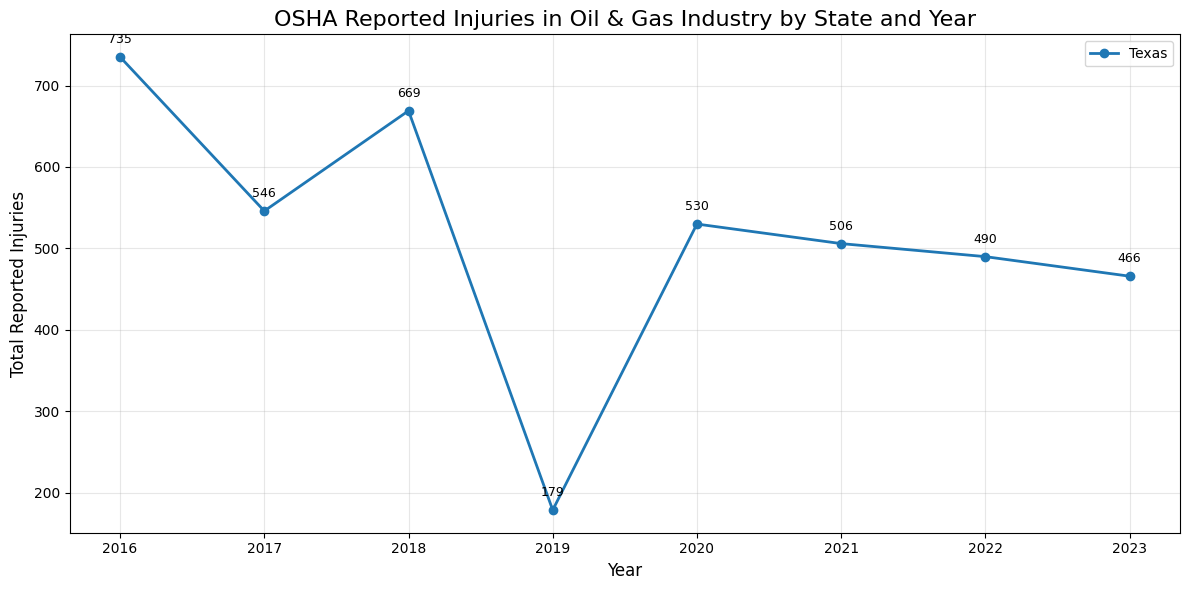

In [9]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import contextily as ctx

# Load environment variables
load_dotenv()

# Create database connection
DB_NAME = os.environ["DB_NAME"]
DB_USER = os.environ["DB_USER"]
DB_PASSWORD = os.environ["DB_PASSWORD"]
DB_HOST = os.environ.get("DB_HOST", "localhost")
DB_PORT = os.environ.get("DB_PORT", "5432")

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Load US county boundaries from GeoPandas
counties_gdf = gpd.read_file("/home/dadams/Downloads/tl_2023_us_county.zip")

# Convert FIPS codes to match your database format
counties_gdf['STATEFP'] = counties_gdf['STATEFP'].astype(str)
counties_gdf['COUNTYFP'] = counties_gdf['COUNTYFP'].astype(str)
counties_gdf['county_fips'] = counties_gdf['STATEFP'] + counties_gdf['COUNTYFP']

# Function to create state maps
def create_osha_injury_map(state_fips, state_name, year=None, title_suffix=""):
    # Query OSHA data from the database
    if year:
        query = f"""
            SELECT 
                c.county_fips,
                c.name AS county_name,
                o.year,
                o.total_cases AS osha_injury_cases
            FROM counties c
            LEFT JOIN osha_injuries o ON c.county_fips = o.county_fips AND o.year = {year}
            WHERE c.state = '{state_fips}'
            ORDER BY osha_injury_cases DESC NULLS LAST
        """
        title = f"OSHA Reported Injuries in Oil & Gas Industry\n{state_name} Counties, {year}{title_suffix}"
    else:
        query = f"""
            SELECT 
                c.county_fips,
                c.name AS county_name,
                NULL as year,
                SUM(o.total_cases) AS osha_injury_cases
            FROM counties c
            LEFT JOIN osha_injuries o ON c.county_fips = o.county_fips
            WHERE c.state = '{state_fips}'
            GROUP BY c.county_fips, c.name
            ORDER BY osha_injury_cases DESC NULLS LAST
        """
        title = f"OSHA Reported Injuries in Oil & Gas Industry\n{state_name} Counties, 2016-2024{title_suffix}"
    
    # Execute query
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    # Filter the US counties shapefile to just this state
    state_counties = counties_gdf[counties_gdf['STATEFP'] == state_fips].copy()
    
    # Merge with OSHA data
    merged_gdf = state_counties.merge(df, on='county_fips', how='left')
    
    # Create the map
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create a custom colormap from white to dark red
    cmap = LinearSegmentedColormap.from_list('injury_cmap', ['#f7f7f7', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#99000d'])
    
    # Handle counties with no data
    merged_gdf['has_data'] = ~merged_gdf['osha_injury_cases'].isna()
    
    # Plot counties with no data in light gray
    merged_gdf[~merged_gdf['has_data']].plot(ax=ax, color='#eeeeee', edgecolor='#999999', linewidth=0.5)
    
    # Plot counties with data using the colormap
    if merged_gdf['has_data'].any():
        vmin = merged_gdf[merged_gdf['has_data']]['osha_injury_cases'].min()
        vmax = merged_gdf[merged_gdf['has_data']]['osha_injury_cases'].max()
        
        # Adjust vmax for better color distribution if very skewed
        if vmax / max(vmin, 1) > 10:
            vmax = vmax * 0.8
        
        merged_gdf[merged_gdf['has_data']].plot(
            column='osha_injury_cases',
            ax=ax,
            cmap=cmap,
            edgecolor='#333333',
            linewidth=0.5,
            vmin=vmin,
            vmax=vmax,
            legend=True,
            legend_kwds={
                'label': 'OSHA Reported Injuries',
                'orientation': 'horizontal',
                'shrink': 0.6,
                'pad': 0.01,
                'aspect': 30
            }
        )
    
    # Add county labels for top counties by injury cases
    # Ensure 'osha_injury_cases' is numeric
    merged_gdf['osha_injury_cases'] = pd.to_numeric(merged_gdf['osha_injury_cases'], errors='coerce')
    
    # Get the top counties by injury cases
    top_counties = merged_gdf.nlargest(5, 'osha_injury_cases')
    for idx, row in top_counties.iterrows():
        if pd.notna(row['osha_injury_cases']):
            # Get centroid for label placement
            centroid = row.geometry.centroid
            ax.annotate(
                text=f"{row['county_name']}\n({int(row['osha_injury_cases'])})",
                xy=(centroid.x, centroid.y),
                ha='center',
                color='black',
                fontweight='bold',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
            )
    
    # Try to add basemap
    try:
        ctx.add_basemap(
            ax, 
            crs=merged_gdf.crs, 
            source=ctx.providers.Stamen.TerrainBackground, 
            alpha=0.4
        )
    except Exception as e:
        print(f"Note: Could not add basemap: {e}")
    
    # Add title and adjust layout
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_axis_off()
    
    # Add legend for counties with no data
    legend_elements = [
        Patch(facecolor='#eeeeee', edgecolor='#999999', label='No OSHA Injury Data')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    # Save figure
    filename = f"osha_injuries_{state_name.lower().replace(' ', '_')}_{year if year else 'all_years'}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return filename, merged_gdf

# Create maps for Texas and Colorado (all years combined)
tx_filename, tx_gdf = create_osha_injury_map('48', 'Texas')
co_filename, co_gdf = create_osha_injury_map('08', 'Colorado')

# Create maps for most recent year (2023)
tx_recent_filename, _ = create_osha_injury_map('48', 'Texas', 2023, " (Most Recent Year)")
co_recent_filename, _ = create_osha_injury_map('08', 'Colorado', 2023, " (Most Recent Year)")

print(f"Maps created and saved as:\n- {tx_filename}\n- {co_filename}\n- {tx_recent_filename}\n- {co_recent_filename}")

# Create a time series plot of injuries by state
def create_time_series_plot():
    query = """
        SELECT 
            c.state, 
            o.year, 
            SUM(o.total_cases) as total_injuries
        FROM counties c
        JOIN osha_injuries o ON c.county_fips = o.county_fips
        WHERE o.total_cases IS NOT NULL
        GROUP BY c.state, o.year
        ORDER BY c.state, o.year
    """
    
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    # Map state FIPS to names
    state_names = {'08': 'Colorado', '48': 'Texas'}
    df['state_name'] = df['state'].map(state_names)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot each state
    for state, group in df.groupby('state_name'):
        ax.plot(group['year'], group['total_injuries'], marker='o', linewidth=2, label=state)
        
        # Add data labels
        for x, y in zip(group['year'], group['total_injuries']):
            ax.annotate(
                f"{int(y)}",
                xy=(x, y),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontsize=9
            )
    
    # Add labels and title
    ax.set_title('OSHA Reported Injuries in Oil & Gas Industry by State and Year', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Total Reported Injuries', fontsize=12)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set x-axis to show all years
    all_years = sorted(df['year'].unique())
    ax.set_xticks(all_years)
    
    plt.tight_layout()
    
    # Save figure
    filename = "osha_injuries_time_series_by_state.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return filename

# Create time series plot
time_series_filename = create_time_series_plot()
print(f"Time series plot created and saved as:\n- {time_series_filename}")